The idea for this network, is to take into account the fact that the car stays flat on the road. Extended control when driving on two wheels only with the car on its side, does not seem necessary. The image area will be cut in two stripes: 

* the distant part, which wiggles as the road turns, and is mostly useful to predict the long term average steering order;
* the close area, which begins after the hood, and moves in a more geometric fashion is response to car motion;

In the close area, the usual machine vision network architectures will be used: 2D convolution layers to extract patterns and features, and dense layers similar to the NVidia network. 

* Image normalization;
* Convolution layer, valid padding, 5x5 kernel, stride 2, 24 layers;
* Convolution layer, valid padding, 5x5 kernel, stride 2, 36 layers;
* Convolution layer, valid padding, 5x5 kernel, stride 2, 48 layers;
* Convolution layer, valid padding, 3x3 kernel, stride 1, 64 layers;
* Convolution layer, valid padding, 3x3 kernel, stride 1, 64 layers, at which point the map is 1 pixel high;
* Flatten; 
* Dense layer 100 neurons;
* Dense layer 50 neurons;
* Dense layer 10 neurons;
* Output 1 neuron, which controls steering;

The image normalization will separate brightness and color information. The brightness will be computed as in the grayscale function, while color information will consist in a one_hot_encoded color class among the 6 primary colors, red, green, blue, cyan, yellow, magenta, plus gray, and saturation information derived as max(r,g,b)-min(r,g,b). The brightness and saturation data are normalized to [-1;+1]. The image preprocessing will be done in the training, and drive.py will be modified to provide image preprocessing as well.

The smaller distant part will be preprocessed in the same way as the close area. However, a motion compensation algorithm will remove the background by substraction from the memorized previous picture. 

In [1]:
import csv

lines = []

# Read lines from log file to retrieve path of center, left and right images
# Note that the csv file is incorrectly generated in locales which use comma as a decimal point.
# The simulator must run in en_US or C locale to get a correct csv file.
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

print('Read '+str(len(lines)),'entries from driving log')
# Visual check that decimal numbers are actually read from the file. If the file is incorrect, only integers
# will be shown, and the number of columns will not be 7.
print(lines[1000])

Read 5168 entries from driving log
['/home/jm/Projets/Udacity/CarND-Behavioral-Cloning-P3/data/IMG/center_2017_08_31_19_22_53_858.jpg', '/home/jm/Projets/Udacity/CarND-Behavioral-Cloning-P3/data/IMG/left_2017_08_31_19_22_53_858.jpg', '/home/jm/Projets/Udacity/CarND-Behavioral-Cloning-P3/data/IMG/right_2017_08_31_19_22_53_858.jpg', '-0.02145923', '1', '0', '30.18984']


In [14]:
# Augment training data using left and right cams, with steering angle offset
# and flipping all images (and reversing the sign of the steering order)
# This should give us around 60k images for training.
# Note that steering angle correction for a side camera is -2 e x/(V²t²)
# where e is the distance between the rear axle and the cameras, x is the lateral offset (x axis) of the camera
# (x<0 for left cam, x>0 for right cam), V and t are current speed and time to rejoin trajectory, and they are
# tuning parameters. Maximum speed is around 30 mph (13 m/s) and at high speed, 2 seconds to rejoin the ideal
# trajectory seems okay. At a slower speed, we can take more time, so operating at constant Vt makes sense.
# We shall therefore take Vt=26, e=2.61m, x=-0.806m for the left cam and x=+0.825 for the right cam.
# The latter values are extracted from the Unity code of the simulator.
def augment_data(lines):
    """
    Takes as input the content of the csv file, and produces two lists: image_paths and steering angles.
    """
    image_paths = []
    measurements = []
    k = -2*2.61/(26^2)
    
    for line in lines:
        # Only images where speed > 0 are added
        speed = float(line[6])
        if speed > 0:
            image_paths += [line[0], line[1], line[2]] # Centre cam, left cam, right cam
            angle = float(line[3])
            measurements += [angle, angle-0.806*k, angle+0.825*k]
    
    return image_paths, measurements

samples = []

cam_paths, angles = augment_data(lines)

# Previous image frame is used to cancel out fixed background using a motion compensation algorithm
# Because images have been added three by three, the previous frame for each cam is three indices before in the list
# The first three frames are discarded: they are used as prior image for the next one
previous_frame = cam_paths[:-3]
cam_paths = cam_paths[3:]
angles = angles[3:]

# Assemble as one list
samples = [ [i,j,k] for i,j,k in zip(previous_frame, cam_paths, angles)]
# All intermediate variables are cleared
del cam_paths, angles, previous_frame
print(samples[0])

/home/jm/Projets/Udacity/CarND-Behavioral-Cloning-P3/data/IMG/center_2017_08_31_19_21_10_640.jpg 0.0
['/home/jm/Projets/Udacity/CarND-Behavioral-Cloning-P3/data/IMG/center_2017_08_31_19_21_10_640.jpg', '/home/jm/Projets/Udacity/CarND-Behavioral-Cloning-P3/data/IMG/center_2017_08_31_19_21_10_716.jpg', 0.0]


In [16]:
# Randomly select 20% of images to use as validation
from sklearn.model_selection import train_test_split

samples_train, samples_valid = train_test_split(samples, test_size=0.2)


In [57]:
import cv2
import numpy as np
import sklearn
from random import shuffle

# Define a generic generator
def generator(samples, batch_size=64):
    batch_size//=2  # All images are flipped...
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            prevs  = []
            images = []
            angles = []
            for batch_sample in batch_samples:
                #prev  = cv2.imread(batch_sample[0])
                # load and trim image to only see section with road
                image = cv2.imread(batch_sample[1])[50:130].astype(np.float32)
                image = cv2.resize(image,(160,40),interpolation=cv2.INTER_AREA)
                angle = float(batch_sample[2])
                # append to batch
                #prevs.append(prev)
                images.append(image)
                angles.append(angle)
                images.append(cv2.flip(image,1))
                angles.append(-angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

train_generator = generator(samples_train)
validation_generator = generator(samples_valid)



In [62]:
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

# Create NVidia-like neural network
model = Sequential()

model.add(BatchNormalization(mode=1,input_shape=(40,160,3)))
print(model.output_shape)
model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2,2), activation='relu'))
print(model.output_shape)
model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2,2), activation='relu'))
print(model.output_shape)
model.add(Convolution2D(48, 3, 3, border_mode='valid', subsample=(2,2), activation='relu'))
print(model.output_shape)
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)
model.add(Dense(100))
print(model.output_shape)
model.add(Dense(50))
print(model.output_shape)
model.add(Dense(10))
print(model.output_shape)
model.add(Dense(1))
print(model.output_shape)
model.compile(loss='mse', optimizer='adam')

print('Keras model ready for training.')

(None, 40, 160, 3)
(None, 18, 78, 24)
(None, 7, 37, 36)
(None, 3, 18, 48)
(None, 1, 16, 64)
(None, 1024)
(None, 100)
(None, 50)
(None, 10)
(None, 1)
Keras model ready for training.


Epoch 1/12
24800/24800 [==============================] - 159s - loss: 0.0265 - val_loss: 0.0181
Epoch 2/12
24800/24800 [==============================] - 167s - loss: 0.0173 - val_loss: 0.0170
Epoch 3/12
24800/24800 [==============================] - 153s - loss: 0.0150 - val_loss: 0.0152
Epoch 4/12
24800/24800 [==============================] - 160s - loss: 0.0134 - val_loss: 0.0135
Epoch 5/12
24800/24800 [==============================] - 169s - loss: 0.0116 - val_loss: 0.0137
Epoch 6/12
24800/24800 [==============================] - 152s - loss: 0.0106 - val_loss: 0.0124
Epoch 7/12
24800/24800 [==============================] - 152s - loss: 0.0095 - val_loss: 0.0123
Epoch 8/12
24800/24800 [==============================] - 153s - loss: 0.0087 - val_loss: 0.0116
Epoch 9/12
24800/24800 [==============================] - 153s - loss: 0.0079 - val_loss: 0.0119
Epoch 10/12
24800/24800 [==============================] - 152s - loss: 0.0069 - val_loss: 0.0116
Epoch 11/12
24800/24800 [====

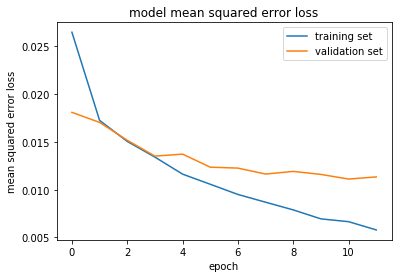

In [63]:
# Train model and save with weights values
# Number of samples is twice array length, because all images are also presented flipped for training.
history_object = model.fit_generator(train_generator, samples_per_epoch = 2*len(samples_train), 
                    validation_data=validation_generator, nb_val_samples = 2*len(samples_valid),
                    nb_epoch=12)
model.save('model.h5')
print('Model saved.')

import matplotlib.pyplot as plt
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


In [59]:
model.fit_generator(train_generator, samples_per_epoch = 2*len(samples_train), 
                    validation_data=validation_generator, nb_val_samples = 2*len(samples_valid),
                    nb_epoch=3, initial_epoch=4)